In [1]:
import os
import sys
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, Input, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.applications import vgg16


from google.colab import drive
drive.mount("/content/gdrive")

Using TensorFlow backend.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
drive_base_path = "/content/gdrive/My Drive/Minor Project/"
path_to_images = drive_base_path + "dataset/ISIC2018_Training_Input/"
path_to_description = drive_base_path + "dataset/ISIC2018_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv"

In [3]:
directory_images = os.listdir(path_to_images)
image_file = directory_images[100]
image_file[:-4]

'ISIC_0033427'

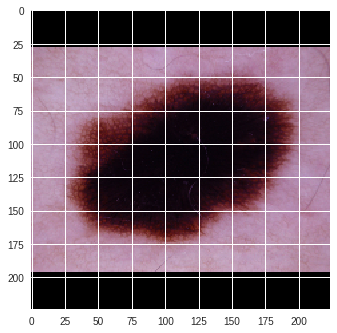

In [4]:
# all image sizes are 600x450
INPUT_SIZE = 224

img = cv2.imread(path_to_images + image_file)
# parse BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
old_size = img.shape[:2] # height, width

# rescale
ratio = float(INPUT_SIZE)/max(old_size)
new_size = tuple([int(x*ratio) for x in old_size])

# resize with new size
img = cv2.resize(img, (new_size[1], new_size[0])) # width, height
# plt.imshow(img)

# padding the image to make it a square
delta_w = INPUT_SIZE - new_size[1]
delta_h = INPUT_SIZE - new_size[0]
top, bottom = delta_h//2, delta_h-(delta_h//2)
left, right = delta_w//2, delta_w-(delta_w//2)

color = [0, 0, 0]
new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, 
                            value=color)

plt.imshow(new_img)

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    data_format="channels_last")

In [0]:
def print_progress_bar(i, total):
    point = total / 100
    increment = total / 20
    
    if i % (2 * point) == 0:
        sys.stdout.write('\r')
        part1 = '=' * int(i / increment)
        part2 = ' ' * int((total - i)// increment)
        part3 = str(i / point)
        full = '[' + part1 + part2 + ']' + part3 + '%'
        sys.stdout.write(full)
        sys.stdout.flush()

In [0]:
def create_train_test(path_to_images, path_to_description, test_split=0.2):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    current = 0
    # total = len(os.listdir(path_to_images))
    
    input_size = 224
    list_of_images = os.listdir(path_to_images)
    number = len(list_of_images)
    for filename in list_of_images:
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        old_size = image.shape[:2]
        
        ratio = float(input_size)/max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])
        
        image = cv2.resize(image, (new_size[1], new_size[0]))
        
        delta_w = input_size - new_size[1]
        delta_h = input_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        
        color = [0, 0, 0]
        new_img = cv2.copyMakeBorder(image, top, bottom, left, right, 
                                     cv2.BORDER_CONSTANT, value=color)
        
        
        arr = np.array(image)
        X_train.append(new_img)
    
        with open(path_to_description, "r") as file:
            for line in file:
                row = line.rstrip("\n").split(",")
                if row[0] == filename[0:-4]:
                    y_train.append([int(float(x)) for x in row[1:]])
        
        print_progress_bar(current, number)
        current += 1
        
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_split, random_state=42)
    return (X_train, X_test, y_train, y_test)

In [0]:
X_train, X_test, y_train, y_test = create_train_test(path_to_images, path_to_description)

[                    ]0.0%

In [0]:
with open(drive_base_path + "dataset/pickled-data/VGG16_ISIC_2018_data.pkl", "wb") as file:
    pickle.dump((X_train, X_test, y_train, y_test), file)

In [0]:
with open(drive_base_path + "dataset/pickled-data/VGG16_ISIC_2018_data.pkl", "rb") as file:
    X_train, X_test, y_train, y_test = pickle.load(file)

In [0]:
datagen.fit(X_train)

In [10]:
print("Training X Size", X_train.shape)
print("Training Y Size (Melanoma, Melanocytic Nevus, Basal Cell Carcinoma, Actinic Keratosis, Benign Keratosis, Dermatofiroma, Vascular Lesion)", y_train.shape)
for i in range(5):
    print(X_train[i].shape, y_train[i])

Training X Size (8012, 224, 224, 3)
Training Y Size (Melanoma, Melanocytic Nevus, Basal Cell Carcinoma, Actinic Keratosis, Benign Keratosis, Dermatofiroma, Vascular Lesion) (8012, 7)
(224, 224, 3) [0 0 0 1 0 0 0]
(224, 224, 3) [0 1 0 0 0 0 0]
(224, 224, 3) [0 0 0 0 1 0 0]
(224, 224, 3) [0 1 0 0 0 0 0]
(224, 224, 3) [0 1 0 0 0 0 0]


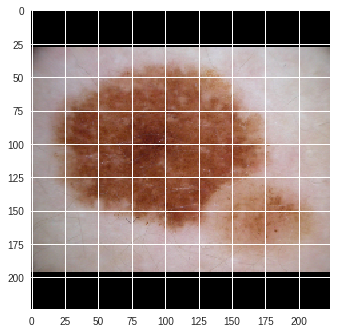

In [11]:
plt.imshow(X_train[100])

In [12]:
base_model = vgg16.VGG16(include_top=False, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(7, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
bloc

In [0]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=10), epochs=15, verbose=1, steps_per_epoch=len(X_train))

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
  26/8012 [..............................] - ETA: 44:26 - loss: 1.3259 - acc: 0.6385

In [180]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

for layer in model.layers[:14]:
    layer.trainable = False
for layer in model.layers[14:]:
    layer.trainable = True

0 input_3
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [181]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=["accuracy"])

history = model.fit(X_train, y_train, batch_size=10, epochs=10, verbose=1, validation_data=(X_test, y_test), shuffle=True)
model.save_weights(drive_base_path + 'models/VGG16_ISIC_cnn.h5')
# model.evaluate(X_test, y_test)

Train on 8012 samples, validate on 2003 samples
Epoch 1/10
8012/8012 [==============================] - 147s 18ms/step - loss: 0.8012 - acc: 0.7348 - val_loss: 0.7628 - val_acc: 0.7374
Epoch 2/10
8012/8012 [==============================] - 146s 18ms/step - loss: 0.5384 - acc: 0.8105 - val_loss: 0.7393 - val_acc: 0.7853
Epoch 3/10
8012/8012 [==============================] - 146s 18ms/step - loss: 0.4105 - acc: 0.8553 - val_loss: 0.7111 - val_acc: 0.7858
Epoch 4/10
8012/8012 [==============================] - 146s 18ms/step - loss: 0.3146 - acc: 0.8894 - val_loss: 0.8022 - val_acc: 0.7853
Epoch 5/10
8012/8012 [==============================] - 146s 18ms/step - loss: 0.2447 - acc: 0.9155 - val_loss: 0.7917 - val_acc: 0.7998
Epoch 6/10
8012/8012 [==============================] - 146s 18ms/step - loss: 0.1601 - acc: 0.9433 - val_loss: 0.7989 - val_acc: 0.7938
Epoch 7/10
8012/8012 [==============================] - 146s 18ms/step - loss: 0.1170 - acc: 0.9618 - val_loss: 0.8406 - val_acc: 

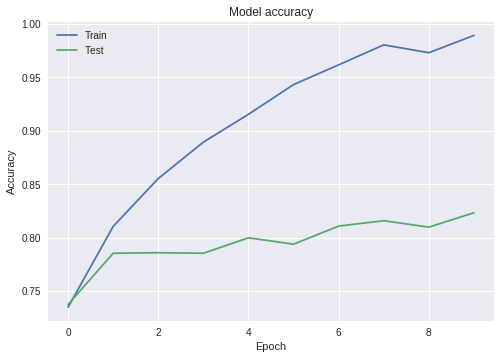

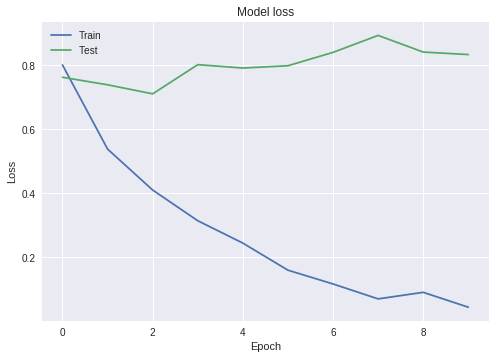

In [182]:
# Plot Training and Validation Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# TESTTING ON ISIC LIVE IMAGE DATA
path_to_images = drive_base_path + "dataset/ISIC2018_Task3_Validation_Input/"

ISIC_0034321


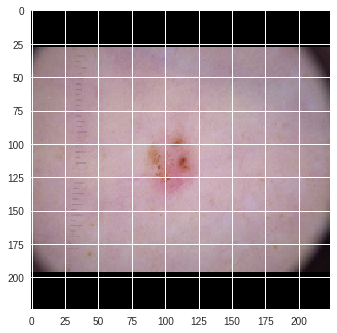

In [0]:
list_of_images = os.listdir(path_to_images)
filename = list_of_images[0]
print(filename[:-4])
input_size = 224

image = cv2.imread(path_to_images + filename)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
old_size = image.shape[:2]

ratio = float(input_size)/max(old_size)
new_size = tuple([int(x * ratio) for x in old_size])

image = cv2.resize(image, (new_size[1], new_size[0]))

delta_w = input_size - new_size[1]
delta_h = input_size - new_size[0]
top, bottom = delta_h//2, delta_h-(delta_h//2)
left, right = delta_w//2, delta_w-(delta_w//2)

color = [0, 0, 0]
new_img = cv2.copyMakeBorder(image, top, bottom, left, right, 
                             cv2.BORDER_CONSTANT, value=color)

plt.imshow(new_img)


In [0]:
def preprocess_images(path_to_images):
    images_list = []
    filename_list = []
    
    current = 0
    # total = len(os.listdir(path_to_images))
    
    input_size = 224
    list_of_images = os.listdir(path_to_images)
    number = len(list_of_images)
    
    for filename in list_of_images:
        filename_list.append(filename[:-4])
        
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        old_size = image.shape[:2]
        
        ratio = float(input_size)/max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])
        
        image = cv2.resize(image, (new_size[1], new_size[0]))
        
        delta_w = input_size - new_size[1]
        delta_h = input_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        
        color = [0, 0, 0]
        new_img = cv2.copyMakeBorder(image, top, bottom, left, right, 
                                     cv2.BORDER_CONSTANT, value=color)

#         arr = np.array(image)
        images_list.append(new_img)
        
        print_progress_bar(current, number)
        current += 1
        
    images_list = np.array(images_list)
    filename_list = np.array(filename_list)
    filename_list = filename_list[:, None]
    return (images_list, filename_list)

In [185]:
x, names = preprocess_images(path_to_images)

[                   ]0.0%

In [186]:
print("X Shape", x.shape)
print("Name Shape", names.shape)

X Shape (193, 224, 224, 3)
Name Shape (193, 1)


In [0]:
model.load_weights(drive_base_path + 'models/VGG16_ISIC_cnn.h5')

In [187]:
predictions = model.predict(x)
classes = (predictions > 0.5).astype(np.float)
print(classes.shape)

(193, 7)


In [188]:
final_output = np.concatenate((names, classes), axis=1)
final_output.shape

(193, 8)

In [0]:
import csv

with open("output.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["image", "MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"])
    writer.writerows(final_output)